In [1]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig


In [2]:
import sys
sys.path.append('../scripts/')

from tqdm.notebook import tqdm
from lora import AutoModelwithLoRA
from iA3 import AutoModelwithiA3
from dora import AutoModelwithDoRA

In [3]:
DATA_SET_NAME = "facebook/flores"

MODEL_NAME = "facebook/xglm-564M"

# Load the model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load the dataset
ds_builder = load_dataset_builder("facebook/flores", "deu_Latn")
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 64
# add labels to the dataset from input_ids
def add_labels(example):
    return {**example, "labels": example["input_ids"]}


# define the tokenizer function
def tokenize_function(examples):
    
    if 'text' in examples.keys():
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    else:
        return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

# tokenize the datasets
tokenized_test_datasets = {}
test_dataloaders = {}
datasets = {}
for lang in LANGUAGES:
    datasets[lang] = load_dataset(DATA_SET_NAME, lang)
    tokenized_test_datasets[lang] = datasets[lang].map(tokenize_function, batched=True, remove_columns=list(ds_builder.info.features.keys()))

    tokenized_test_datasets[lang].set_format(type='torch', columns=['input_ids', 'attention_mask'], format_kwargs={'dtype': torch.long})
    tokenized_test_datasets[lang] = tokenized_test_datasets[lang].map(add_labels)
    test_dataloaders[lang] = DataLoader(tokenized_test_datasets[lang]["devtest"], batch_size=4, shuffle=False, drop_last=True)

/CT/Hands2/work/NNTI-project/env_nnti/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/CT/Hands2/work/NNTI-project/env_nnti/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [4]:
def test(model, dataloaders, device='cuda'):
    
    losses = {lang: [] for lang in LANGUAGES}
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for lang in LANGUAGES:
            print(lang)
            for batch in tqdm(dataloaders[lang]):
                for key in batch:
                    batch[key] = batch[key].to(device)
                outputs = model(**batch)
                loss = outputs.loss
                losses[lang].append(loss.item())
            
            

    return losses

def visualize(losses, strategy=""):
    # plot the mean losses per language as a bar chart
    mean_losses = {lang: torch.mean(torch.tensor(losses[lang])) for lang in LANGUAGES}
    langs = list(mean_losses.keys())
    values = list(mean_losses.values())

    # increase spacing between x axis labels and make the bars colorful


    plt.bar(langs, values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
    plt.xticks(rotation=45)
    plt.ylabel('Mean Loss')
    plt.xlabel('Language')
    plt.title(f'Mean Loss per Language: {strategy}')
    plt.show()


'_'

In [34]:
#### Full Params no finetuning

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"

# losses = test(model, test_dataloaders, device)

# visualize(losses)

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

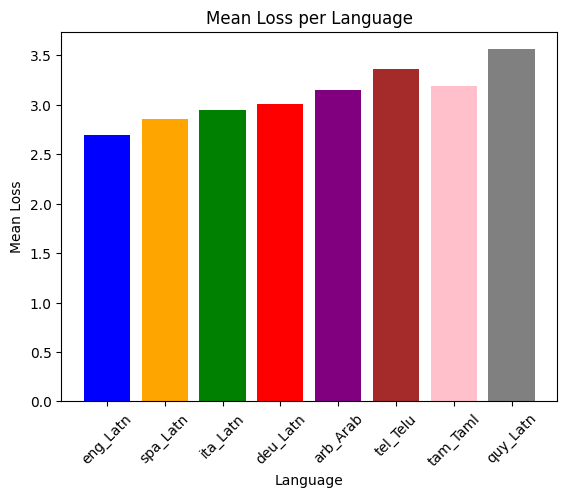

In [19]:
##### Full Params with finetuning
MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_full__2024-03-16_00-46/best_model.pt"
model.load_state_dict(torch.load(MODEL_PATH))

losses_full = test(model, test_dataloaders, device)
visualize(losses_full, "Full Params")

#### BitFit full dataset

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

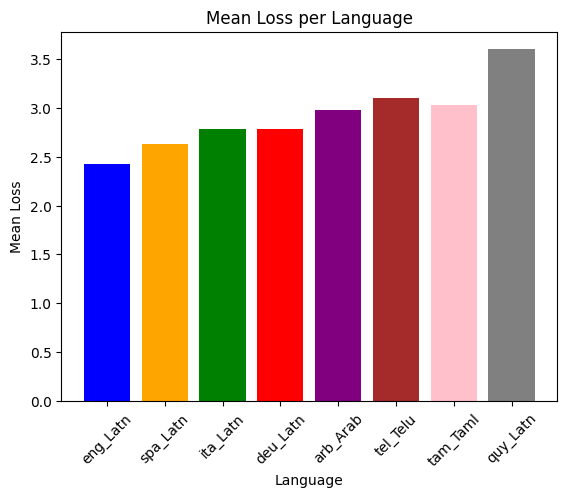

In [20]:
MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_bitfit__2024-03-16_00-45/best_model.pt"

# Load the model state_dict 
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.load_state_dict(torch.load(MODEL_PATH))

losses_bitfit = test(model, test_dataloaders, device)

visualize(losses_bitfit,"BitFit")


##### LoRA Rank 8

In [22]:
import sys
sys.path.append("../scripts")

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

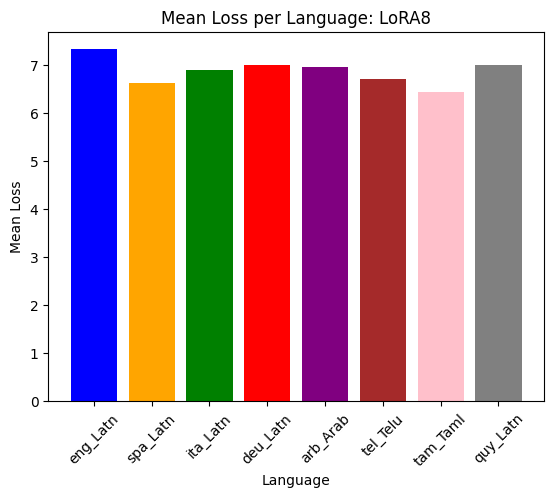

In [33]:
from lora import AutoModelwithLoRA

MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_lora_8_16__2024-03-16_16-49/best_model.pt"
RANK=8
ALPHA=16

# Load the model state_dict 
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
lora_model = AutoModelwithLoRA(MODEL_NAME, rank=RANK, alpha=ALPHA)
lora_model.load_state_dict(torch.load(MODEL_PATH))

losses_lora_8 = test(lora_model, test_dataloaders, device)

visualize(losses_lora_8, strategy="LoRA8")


#### LoRA 16

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

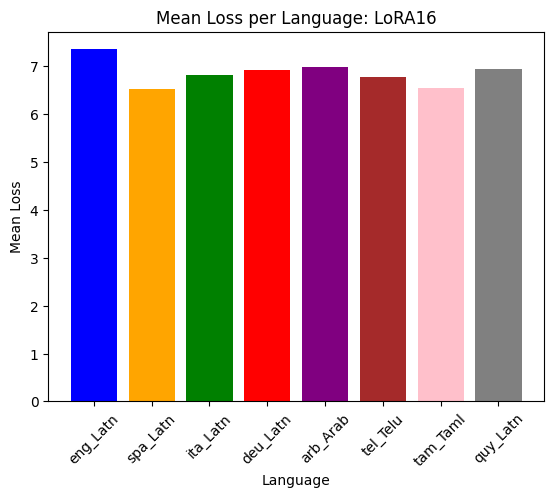

In [34]:
MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_lora__2024-03-16_00-44/best_model.pt"
RANK=16
ALPHA=16

# Load the model state_dict
lora_model_16 = AutoModelwithLoRA(MODEL_NAME, rank=RANK, alpha=ALPHA)
lora_model_16.load_state_dict(torch.load(MODEL_PATH))

losses_lora_16 = test(lora_model_16, test_dataloaders, device)

visualize(losses_lora_16, "LoRA16")


#### iA3

In [5]:
from iA3 import AutoModelwithiA3

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

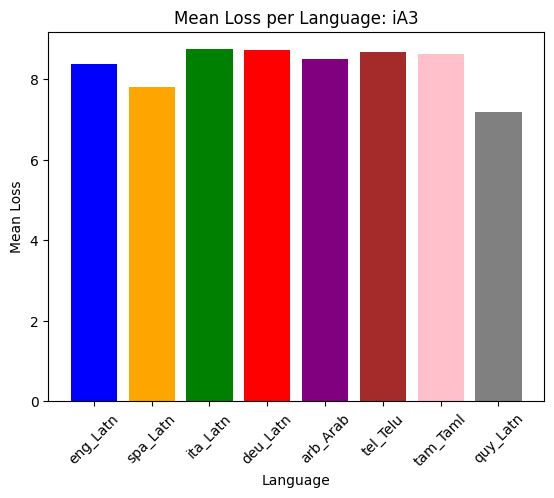

In [6]:
MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_iA3__2024-03-16_01-09/best_model.pt"
device = 'cuda'
# Load the model state_dict
ia3_model = AutoModelwithiA3(MODEL_NAME)
ia3_model.load_state_dict(torch.load(MODEL_PATH))

losses_ia3 = test(ia3_model, test_dataloaders, device)

visualize(losses_ia3, "iA3")

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

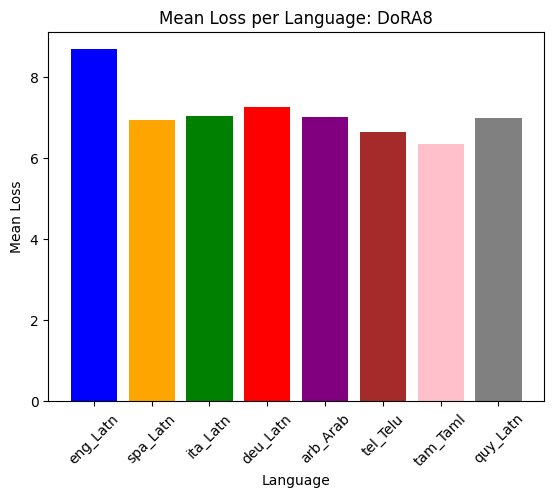

In [8]:
#### DoRA 8
from dora import AutoModelwithDoRA

MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_dora_8_16__2024-03-16_17-39/best_model.pt"
RANK=8
ALPHA=16

# Load the model state_dict
dora_model_8 = AutoModelwithDoRA(MODEL_NAME, rank=RANK, alpha=ALPHA)
dora_model_8.load_state_dict(torch.load(MODEL_PATH))

losses_dora_8 = test(dora_model_8, test_dataloaders, device)

visualize(losses_dora_8, "DoRA8")

eng_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/253 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/253 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/253 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/253 [00:00<?, ?it/s]

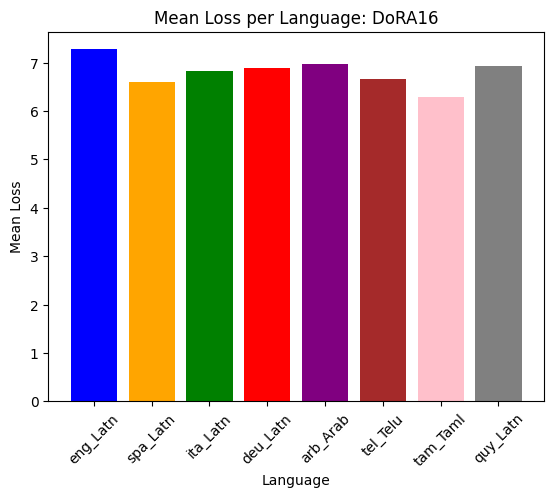

In [16]:
#### DoRa 16

MODEL_PATH = "/CT/Hands2/work/NNTI-project/scripts/trained_models/xglm_dora_16_16__2024-03-16_17-40/best_model.pt"
RANK=16
ALPHA=16
# Load the model state_dict
dora_model_16 = AutoModelwithDoRA(MODEL_NAME, rank=RANK, alpha=ALPHA)
dora_model_16.load_state_dict(torch.load(MODEL_PATH))

losses_dora_16 = test(dora_model_16, test_dataloaders, device)

visualize(losses_dora_16, "DoRA16")

##### 


In [10]:
# save all losses in jsons
import json

# with open("losses_full.json", "w") as f:
#     json.dump(losses_full, f)

# with open("losses_bitfit.json", "w") as f:
#     json.dump(losses_bitfit, f)

# with open("losses_lora_8.json", "w") as f:
#     json.dump(losses_lora_8, f)

# with open("losses_lora_16.json", "w") as f:
#     json.dump(losses_lora_16, f)

# with open("losses_ia3.json", "w") as f:
#     json.dump(losses_ia3, f)

# with open("losses_dora_8.json", "w") as f:
#     json.dump(losses_dora_8, f)

# with open("losses_dora_16.json", "w") as f:
#     json.dump(losses_dora_16, f)




## Task 3 Hidden representations visualization

In [9]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [11]:
# take random 5 samples from each lang dataloaders
# get the embeddings from the model
# apply PCA and TSNE to the embeddings
# plot the embeddings

# sample the dataloaders 4 samples from each language
samples = {lang: [] for lang in LANGUAGES}
for lang in LANGUAGES:
    for i, batch in enumerate(test_dataloaders[lang]):
        if i > 0:
            break
        samples[lang].append(batch)


In [21]:
tokenizer.decode(samples["eng_Latn"][0]["input_ids"][0], samples["eng_Latn"][0]["attention_mask"][0], skip_special_tokens=True)

TypeError: decode() got multiple values for argument 'skip_special_tokens'

In [26]:
# decode the input_ids
def decode_input_ids(input_ids, attention_mask):
    return tokenizer.decode(input_ids, attention_mask, skip_special_tokens=True)

# get a sample from each language
samples = {lang: [] for lang in LANGUAGES}
for lang in LANGUAGES:
    for i, batch in enumerate(test_dataloaders[lang]):
        if i > 0:
            break
        samples[lang].append(batch)


# DECODE THE INPUT_IDS
for lang in LANGUAGES:
    for i in range(len(samples[lang])):
        samples[lang][i]["decoded"] = tokenizer.decode(samples[lang][i]["input_ids"][0], skip_special_tokens=True)

In [40]:
samples["eng_Latn"][0]["input_ids"]

tensor([[     2,    268,   1953,      8,   1800,  36205,     53,   9903,      8,
          23855,  73815,    196,  37048,     48,  27643,      7,     67,     11,
           6965,  10526,   2202,  47389, 239376,     40,   4328,  56152,     11,
          91176,     48,   7387,     22,    132,  13096,      5,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1],
        [     2,   8968,  14414,    386, 108759,    196,     32,   1631,   6170,
              7,     15,  24877,  64903,     16,     22,     11, 115902,  43895,
           4923,  83671,  12542,     94,     32,  25417,   1567,   3813,  79375,
          73104,     22, 122953,  41891,      4,   8968,  14414,      5,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
          

In [45]:
from task2 import extract_hidden_representations

# get the hidden representations
hidden_reps = []
for s in samples["eng_Latn"]:
    hidden_reps.append(extract_hidden_representations(s, model))

    

AttributeError: 'NoneType' object has no attribute 'shape'

In [42]:
for layer, layer_hidden_states in enumerate(hidden_reps):
    print(f"Layer {layer}: {layer_hidden_states.shape}")

TypeError: 'NoneType' object is not iterable

In [36]:
for layer, layer_hidden_states in enumerate(hidden_reps):
                    # print(layer_hidden_states.size())
                    # print(example['attention_mask'][0].size()
                    sentence_index = 0

                    for sentence in layer_hidden_states:
                        # save sentence details in file
                        if(layer == 0): # only need to save it once
                            f.create_dataset(
                                f"{lang}/Sample_{example['id'][sentence_index]}/sentence",
                                data=example['sentence'][sentence_index]
                            )
                            # save token_ids in file
                            token_ids_sample = example['input_ids'][sentence_index]
                            token_ids_saved = []
                            mask_index = 0
                            for mask in example['attention_mask'][sentence_index]:
                                if(mask == 1): # only save non-padding tokens
                                    token_ids_saved.append(token_ids_sample[mask_index])
                                mask_index +=1
                            token_ids_saved = token_ids_saved[1:] # don't save first token, string start token
                            f.create_dataset(
                                f"{lang}/Sample_{example['id'][sentence_index]}/input_ids",
                                data=token_ids_saved
                            )
                        for token_index, token_hidden_state in enumerate(sentence):
                            # Skip 1st token, marks the start of the sentence
                            if(token_index == 0):
                                continue

                            # Skip padding tokens
                            if (example['attention_mask'][sentence_index][token_index] == 0):
                                continue

                            # Save hidden representation for each token
                            # print(token_index)
                            if device == torch.device('cuda'):
                                f.create_dataset(
                                    f"{lang}/Sample_{example['id'][sentence_index]}/layers/layer_{layer}/token_{token_index}",
                                    data=token_hidden_state.cpu().numpy()
                                )
                            else:
                                f.create_dataset(
                                    f"{lang}/Sample_{example['id'][sentence_index]}/layers/layer_{layer}/token_{token_index}",
                                    data=token_hidden_state.numpy()
                                )

                        # Calculate mean-pooled sentence representation
                        if device == torch.device('cuda'):
                            mean_pooled_sentence = np.mean(sentence.cpu().numpy(), axis=0)
                        else:
                            mean_pooled_sentence = np.mean(sentence.numpy(), axis=0)
                        # Save mean-pooled sentence representation
                        # print(f'Creating {lang}/Sample #{example["id"][sentence_index]}/mean_pooled_sentence')
                        f.create_dataset(
                            f"{lang}/Sample_{example['id'][sentence_index]}/layers/layer_{layer}/mean_pooled_sentence",
                            data=mean_pooled_sentence
                        )
                        # print(f'Created {lang}/Sample #{example["id"][sentence_index]}/mean_pooled_sentence')
                        sentence_index += 1